<a href="https://colab.research.google.com/github/heidarimohsen92/YOLOv3_Custom_Object_Colab/blob/main/YOLOv3_Traffic_Signs_Detection_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow

# Connect google drive

In [2]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
# !ls /mydrive

Mounted at /content/gdrive


# Download and Load the `Traffic Signs Dataset` from kaggle

In [4]:
!pip install kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d valentynsichkar/traffic-signs-dataset-in-yolo-format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 95% 238M/250M [00:03<00:00, 51.9MB/s]
100% 250M/250M [00:03<00:00, 66.9MB/s]


# Cloning and Building Darknet

In [5]:
# Clone Darknet
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15424, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 15424 (delta 0), reused 1 (delta 0), pack-reused 15423
Receiving objects: 100% (15424/15424), 14.05 MiB | 14.02 MiB/s, done.
Resolving deltas: 100% (10364/10364), done.


In [6]:
# change makefile to have GPU and OPENCV enabled
# Configure Darknet
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [7]:
# Compile DarkNet
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# Configure Darknet network for training YOLO V3

In [8]:
# Make a copy of yolov3.cfg
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg

In [9]:
# Change lines in yolov3.cfg file
!sed -i 's/batch=1/batch=32/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 8000/' cfg/yolov3_training.cfg # max_batches = (classes*2000)
!sed -i '610 s@classes=80@classes=4@' cfg/yolov3_training.cfg # classes=4
!sed -i '696 s@classes=80@classes=4@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=4@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=27@' cfg/yolov3_training.cfg # filters=(classes + 5)x3
!sed -i '689 s@filters=255@filters=27@' cfg/yolov3_training.cfg 
!sed -i '776 s@filters=255@filters=27@' cfg/yolov3_training.cfg

In [10]:
# Create folder on google drive so that we can save there the weights
!mkdir "/mydrive/YOLO_v3"

mkdir: cannot create directory ‘/mydrive/yolov3’: File exists


# Create file `obj.names`

In [11]:
# Create .names files
# Names of classes
!echo -e 'prohibitory\ndanger\nmandatory\nother' > data/obj.names

# Create file `obj.data`

In [12]:
# Create .data file 
!echo -e 'classes = 4\ntrain = data/train.txt\nvalid = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/YOLO_v3' > data/obj.data

## Extract Images

The images need to be inside a zip archive called "images.zip" and they need to be inside the folder "yolov3" on Google Drive

In [13]:
!cp "/content/dataset/ts_data.data"  "/content/darknet/cfg/"

cp: cannot stat '/content/dataset/ts_data.data': No such file or directory


In [14]:
# Create a folder and unzip image dataset
!mkdir data/obj
!unzip /content/traffic-signs-dataset-in-yolo-format.zip -d /content/dataset
# move dataset to darknet directory
!mv "/content/dataset/ts/ts"  "/content/darknet/data/obj/"
# copy files to darknet directory
!cp "/content/dataset/test.txt"  "/content/darknet/data/"
!cp "/content/dataset/train.txt"  "/content/darknet/data/"
!cp "/content/dataset/yolov3_ts_train.cfg"  "/content/darknet/cfg/"
!cp "/content/dataset/yolov3_ts_test.cfg"  "/content/darknet/cfg/"

Archive:  /content/traffic-signs-dataset-in-yolo-format.zip
  inflating: /content/dataset/classes.names  
  inflating: /content/dataset/getting-full-path.py  
  inflating: /content/dataset/test.txt  
  inflating: /content/dataset/traffic-sign-to-test.mp4  
  inflating: /content/dataset/train.txt  
  inflating: /content/dataset/ts/ts/00000.jpg  
  inflating: /content/dataset/ts/ts/00000.txt  
  inflating: /content/dataset/ts/ts/00001.jpg  
  inflating: /content/dataset/ts/ts/00001.txt  
  inflating: /content/dataset/ts/ts/00002.jpg  
  inflating: /content/dataset/ts/ts/00002.txt  
  inflating: /content/dataset/ts/ts/00003.jpg  
  inflating: /content/dataset/ts/ts/00003.txt  
  inflating: /content/dataset/ts/ts/00004.jpg  
  inflating: /content/dataset/ts/ts/00004.txt  
  inflating: /content/dataset/ts/ts/00005.jpg  
  inflating: /content/dataset/ts/ts/00005.txt  
  inflating: /content/dataset/ts/ts/00006.jpg  
  inflating: /content/dataset/ts/ts/00006.txt  
  inflating: /content/dataset

In [15]:
# replace test.txt directory
with open("/content/darknet/data/test.txt") as r:
  text = r.read().replace("/home/my_name", "data/obj")
with open("/content/darknet/data/test.txt", "w") as w:
  w.write(text)

In [16]:
# replace train.txt directory
with open("/content/darknet/data/train.txt") as r:
  text = r.read().replace("/home/my_name", "data/obj")
with open("/content/darknet/data/train.txt", "w") as w:
  w.write(text)

In [17]:
# # Create train.txt file
# import glob
# images_list = glob.glob("data/obj/ts/*.jpg")
# with open("data/train.txt", "w") as f:
#     f.write("\n".join(images_list))

## Start the training

In [17]:
# Download pre-trained weights for the convolutional layers file
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-06-27 05:46:28--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  23.2MB/s    in 7.4s    

2022-06-27 05:46:36 (21.0 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [ ]:
# Start training
!./darknet detector train data/obj.data cfg/yolov3_ts_train.cfg darknet53.conv.74 -map -dont_show
# !./darknet detector train data/obj.data cfg/yolov3_training.cfg darknet53.conv.74 -map -dont_show

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.741596), count: 3, class_loss = 0.959635, iou_loss = 0.195610, total_loss = 1.155245 
 total_bbox = 77392, rewritten_bbox = 0.148594 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.763132), count: 1, class_loss = 0.001416, iou_loss = 0.111353, total_loss = 0.112769 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00

# Loading trained weights and cfg file into the Network

In [18]:
obj_file = "/content/darknet/data/obj.names"
obj_classes = []
net_config = "/content/darknet/cfg/yolov3_ts_test.cfg"
net_weights = "/mydrive/YOLO_v3/yolov3_ts_train_best.weights"
blob_size = 320
confidence_threshold = 0.25
nms_threshold = 0.3

with open(obj_file, "rt") as f:
    obj_classes = f.read().rstrip("\n").split("\n")

net = cv2.dnn.readNetFromDarknet(net_config, net_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [30]:
def findObjects(output, img):
    img_h, img_w, img_c = img.shape
    bboxes = []
    class_ids = []
    confidences = []

    for cell in output:
        for detect_vector in cell:
            scores = detect_vector[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold:
                w,h = int(detect_vector[2] * img_w), int(detect_vector[3] * img_h)
                x,y = int((detect_vector[0] * img_w) - w/2), int((detect_vector[1] * img_h) - h/2)
                bboxes.append([x,y,w,h])
                class_ids.append(class_id)
                confidences.append(float(confidence))
    indices = cv2.dnn.NMSBoxes(bboxes, confidences, confidence_threshold, nms_threshold)
    # print(indices)
    for i in indices:
        i = i[0]
        bbox = bboxes[i]
        x,y,w,h = bbox[0], bbox[1], bbox[2], bbox[3]
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img, f'{obj_classes[class_ids[i]].upper()} {int(confidences[i] * 100)}%',
                    (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

# Test single image

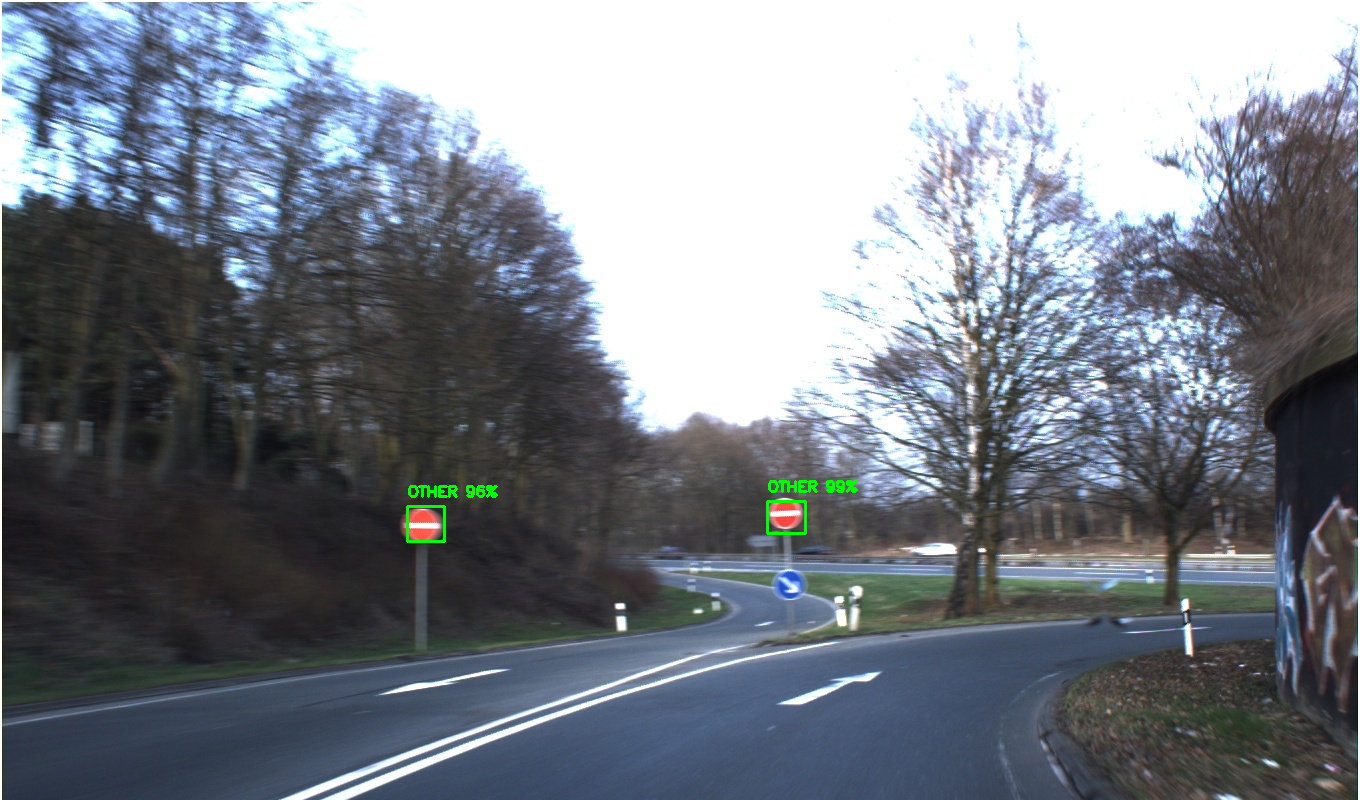

-1

In [31]:
img = cv2.imread('/content/darknet/data/obj/ts/00446.jpg')

blob = cv2.dnn.blobFromImage(img, scalefactor=1/255, size=(blob_size,blob_size),mean=(0,0,0)
                                ,swapRB=True,crop=False)

net.setInput(blob)
out_names = net.getUnconnectedOutLayersNames()
output = net.forward(out_names)
findObjects(output, img)

cv2_imshow(img)
cv2.waitKey(0)

## Reading input video

In [21]:
cap = cv2.VideoCapture('/content/dataset/traffic-sign-to-test.mp4')
frame_size = (np.int64(cap.get(3)), np.int64(cap.get(4)))
frame_rate = np.int64(cap.get(5))
result = cv2.VideoWriter('/mydrive/YOLO_v3/result.mp4', cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, frame_size)

# Variable for counting total amount of frames
f = 0
# Variable for counting total processing time
t = 0

while True:
    success, frame = cap.read()
    # If the frame was not retrieved
    if not success:
        break

    blob = cv2.dnn.blobFromImage(frame, scalefactor=1/255, size=(blob_size,blob_size),mean=(0,0,0)
                                ,swapRB=True,crop=False)

    net.setInput(blob)
    out_names = net.getUnconnectedOutLayersNames()
    start = time.time()
    output = net.forward(out_names)
    end = time.time()
    # Increasing counters
    f += 1
    t += end - start
    # Spent time for current frame
    print('Frame number {0} took {1:.5f} seconds'.format(f, end - start))

    findObjects(output, frame)

    # cv2_imshow(frame)
    # if cv2.waitKey(1) == ord('q'):
    #     break
    result.write(frame)

result.release()
cap.release() 
cv2.destroyAllWindows()

Frame number 1 took 1.36360 seconds
Frame number 2 took 1.21090 seconds
Frame number 3 took 1.22583 seconds
Frame number 4 took 1.21332 seconds
Frame number 5 took 1.23890 seconds
Frame number 6 took 1.23000 seconds
Frame number 7 took 1.21195 seconds
Frame number 8 took 1.20912 seconds
Frame number 9 took 1.20881 seconds
Frame number 10 took 1.22874 seconds
Frame number 11 took 1.21978 seconds
Frame number 12 took 1.21149 seconds
Frame number 13 took 1.24485 seconds
Frame number 14 took 1.21775 seconds
Frame number 15 took 1.20316 seconds
Frame number 16 took 1.22160 seconds
Frame number 17 took 1.21227 seconds
Frame number 18 took 1.20709 seconds
Frame number 19 took 1.21230 seconds
Frame number 20 took 1.21146 seconds
Frame number 21 took 1.20356 seconds
Frame number 22 took 1.24191 seconds
Frame number 23 took 1.21476 seconds
Frame number 24 took 1.21091 seconds
Frame number 25 took 1.21627 seconds
Frame number 26 took 1.20702 seconds
Frame number 27 took 1.23313 seconds
Frame numb